# Churn detection 

Used dataset contains bank's customer data 

### Libraries imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sweetviz as sv
import warnings

from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.svm import SVC
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from xgboost import XGBClassifier

%matplotlib inline
warnings.filterwarnings('ignore')
rndm = 101

C:\Users\brtkr\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Data load

In [2]:
churn = pd.read_csv('../Data/Churn_Modelling.csv')
churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
churn.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

## Data understanding

### Exploration

In [4]:
churn.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


In [5]:
churn.describe(include=object).T

,count,unique,top,freq
Geography,10000,3,France,5014
Gender,10000,2,Male,5457


In [6]:
churn.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 1.9 MB


In [7]:
churn.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

### Visualisation

                                             |                                             | [  0%]   00:00 ->…


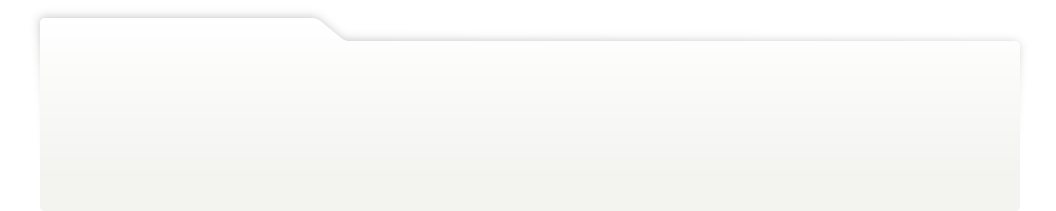
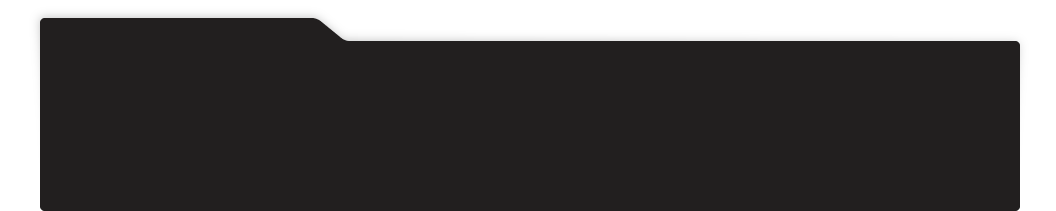
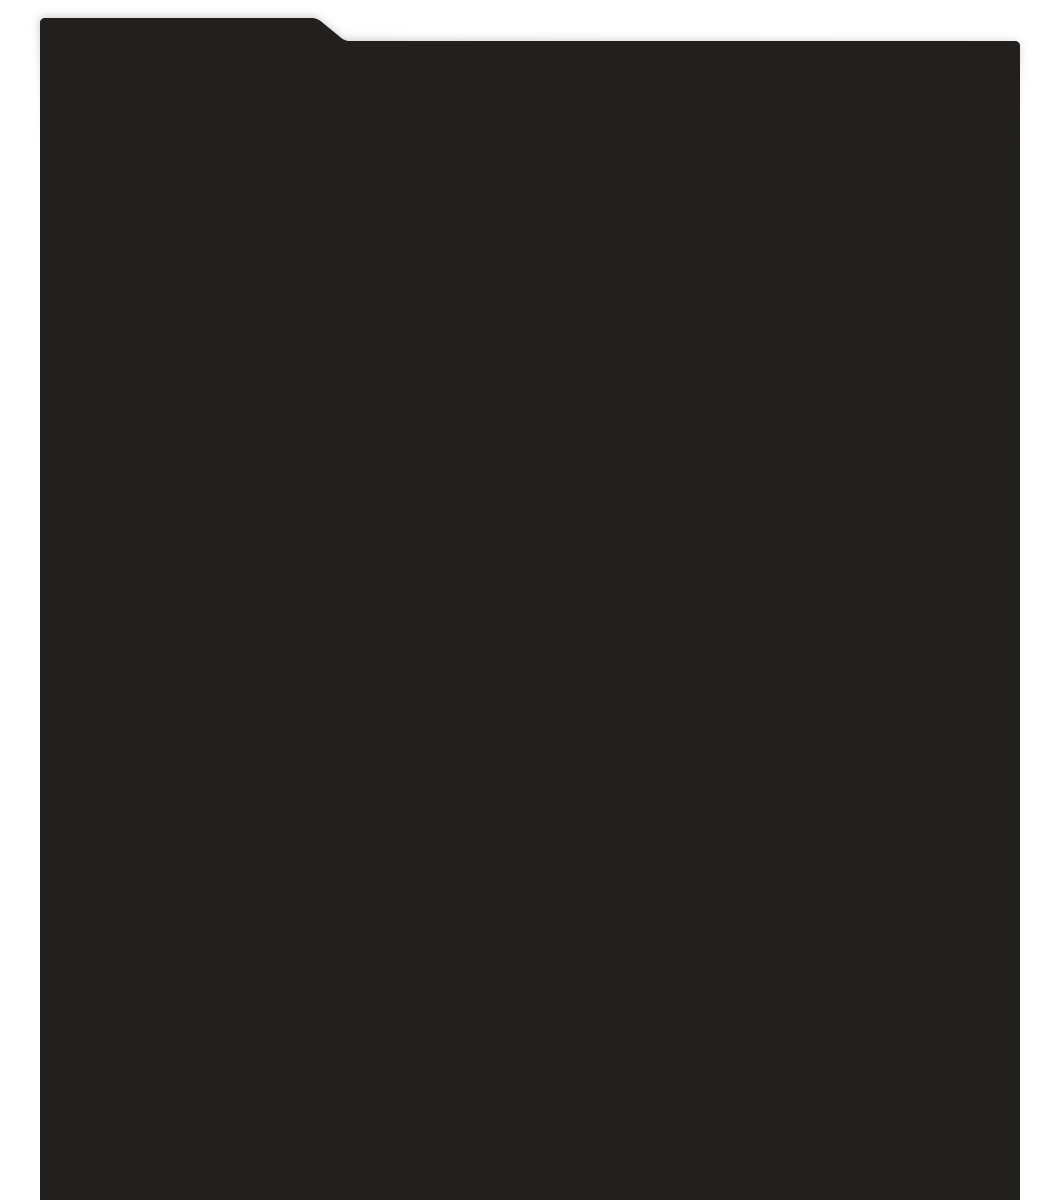
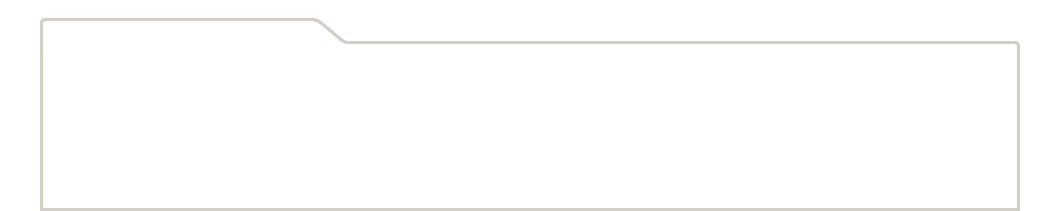
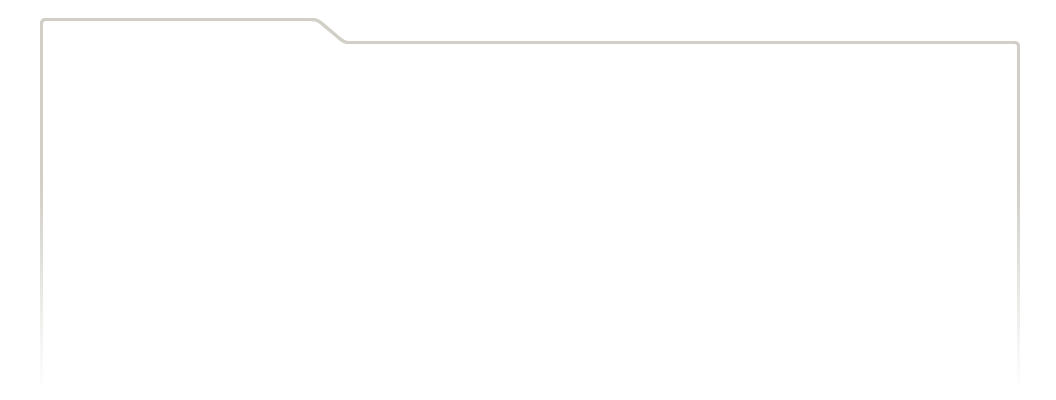
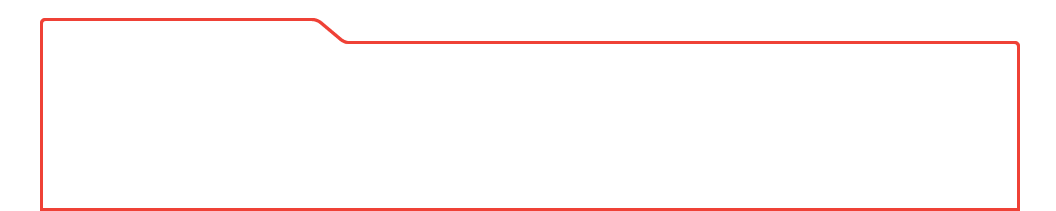
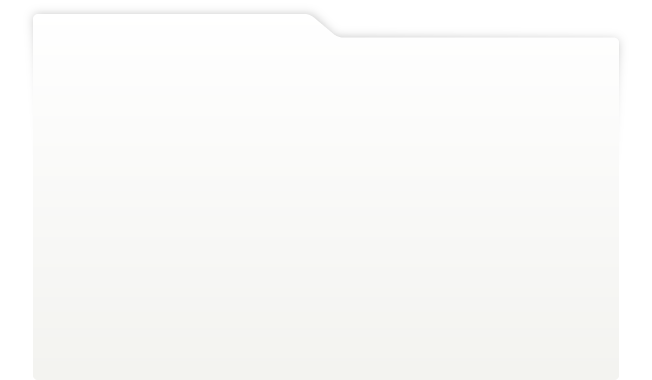
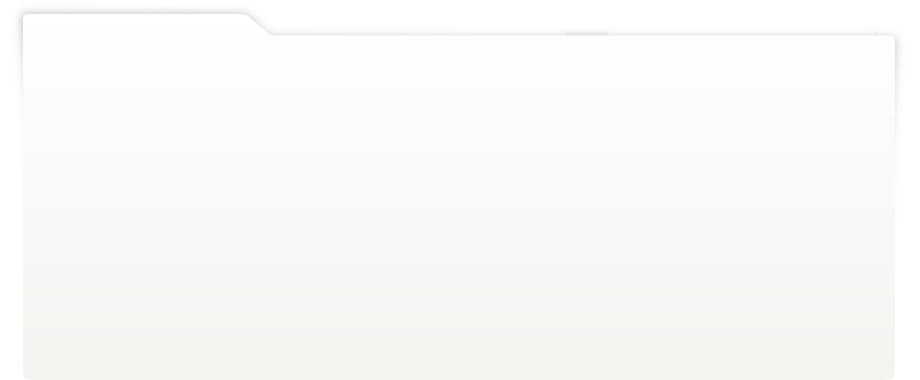
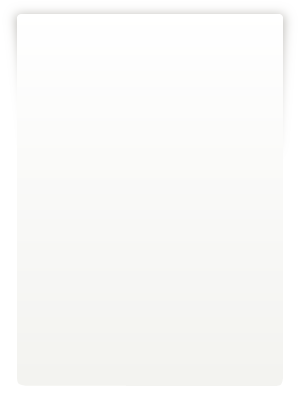
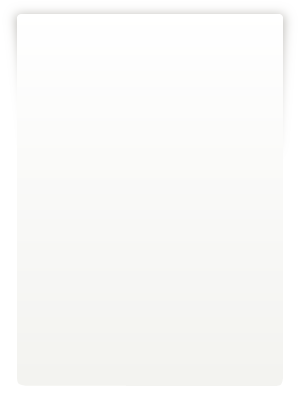
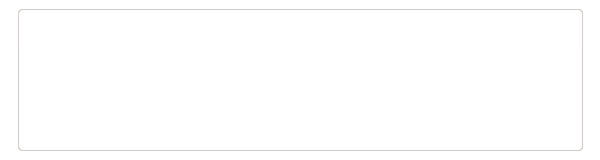
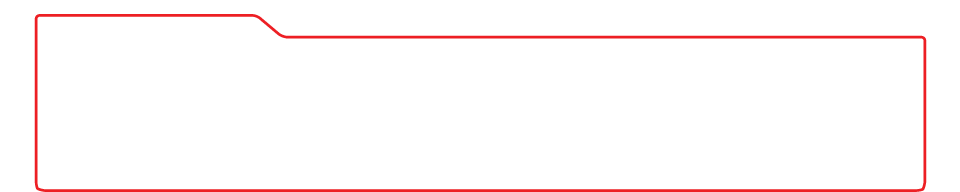
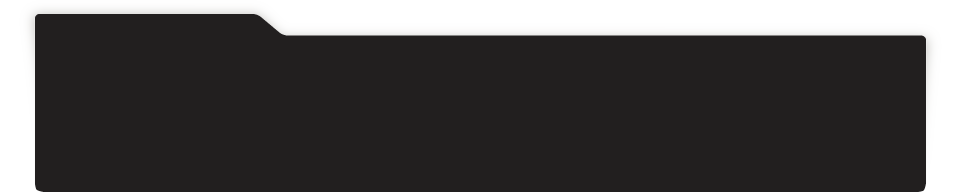
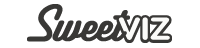
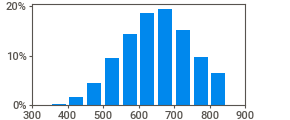
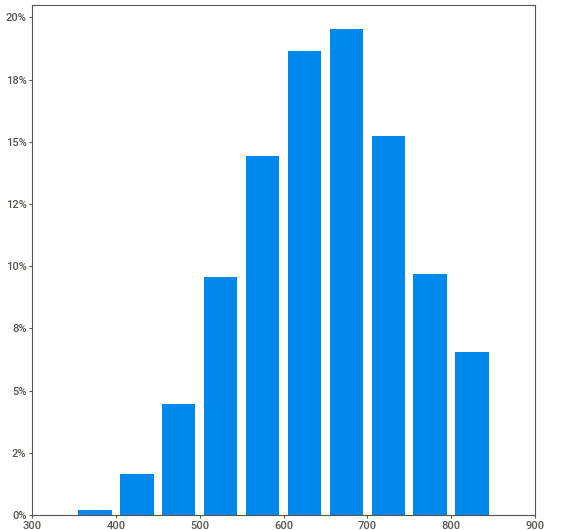
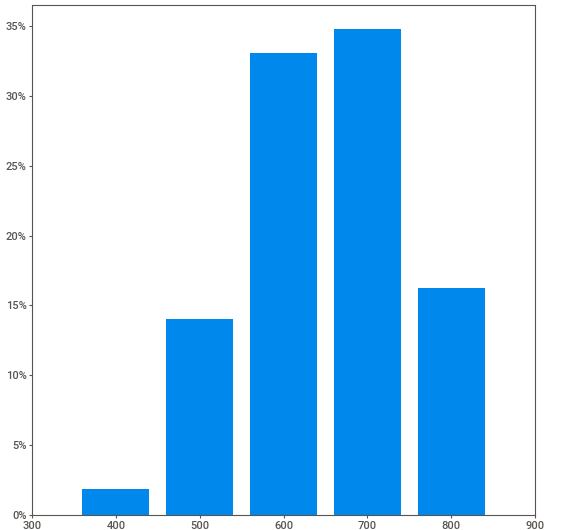
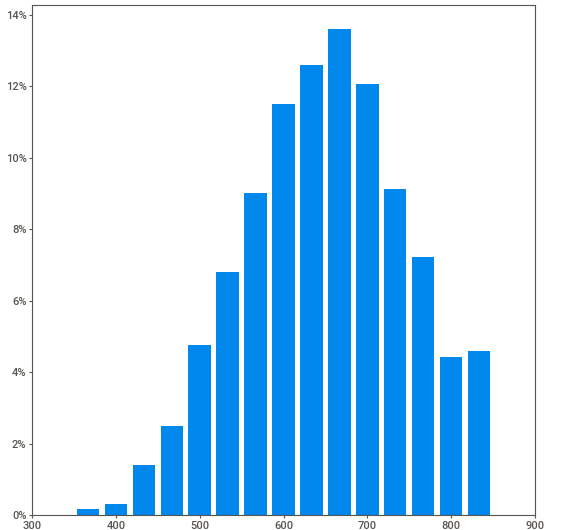
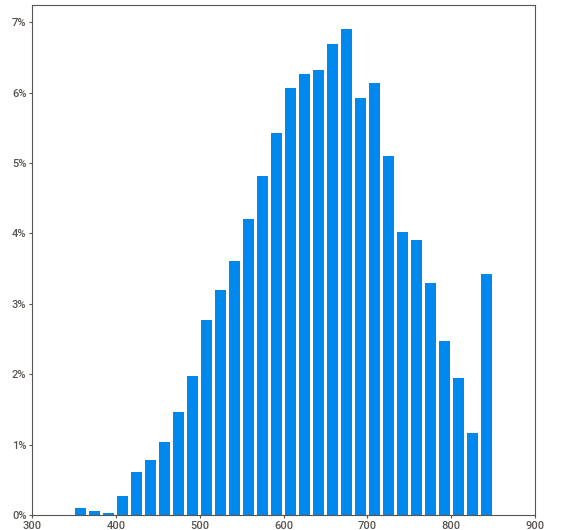
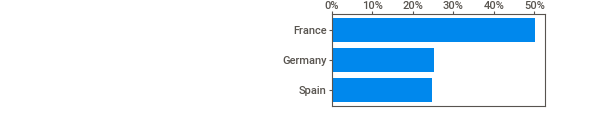
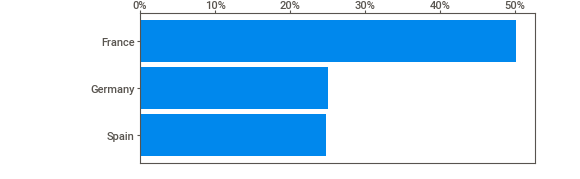
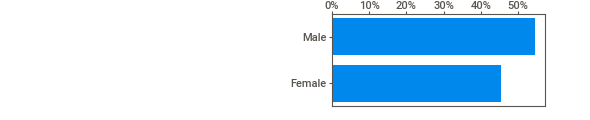
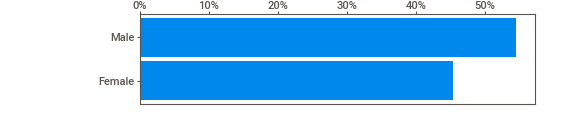
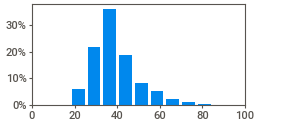
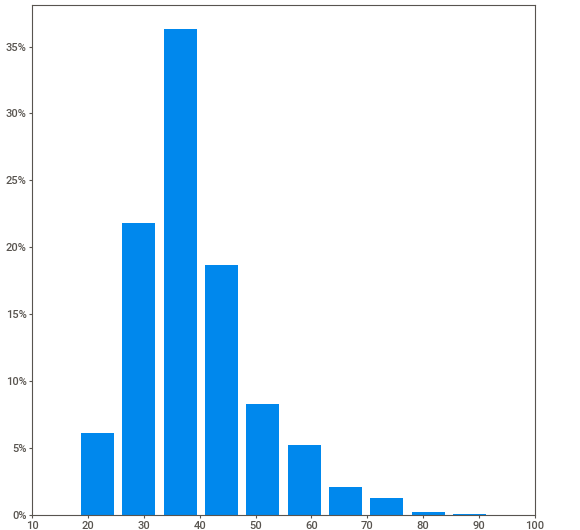
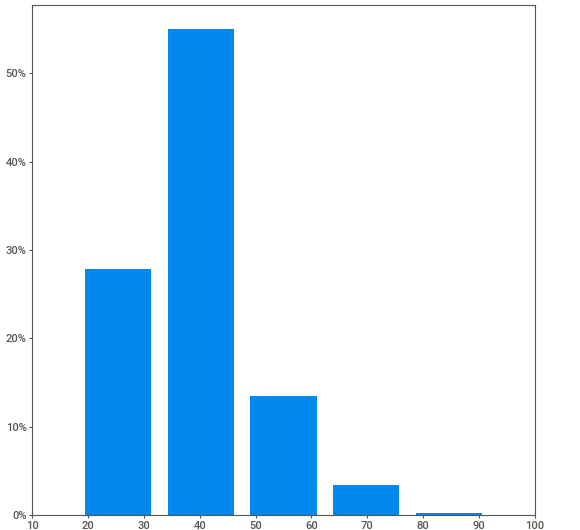
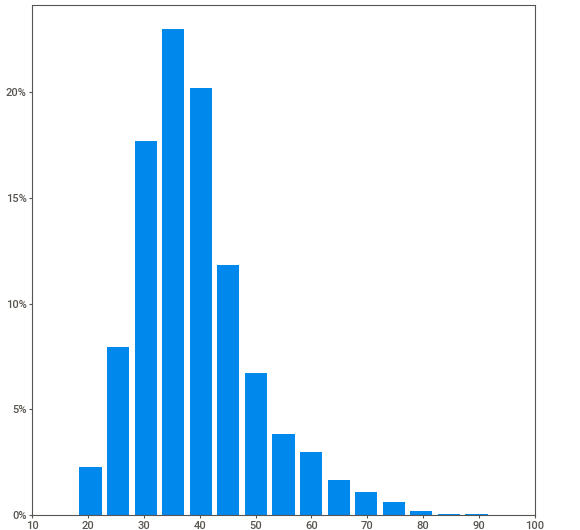
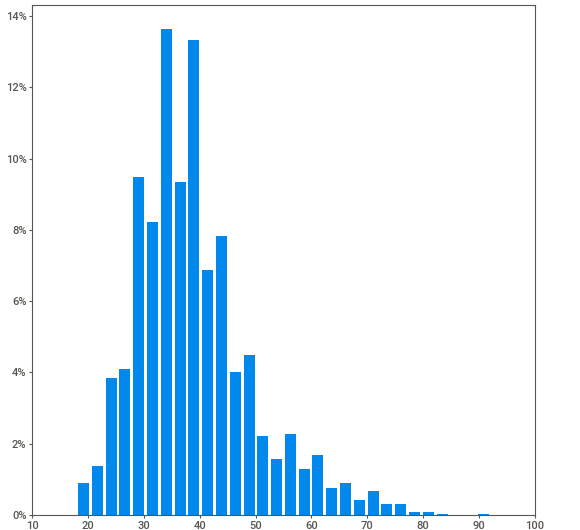
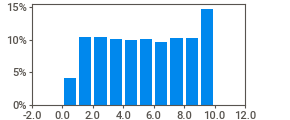
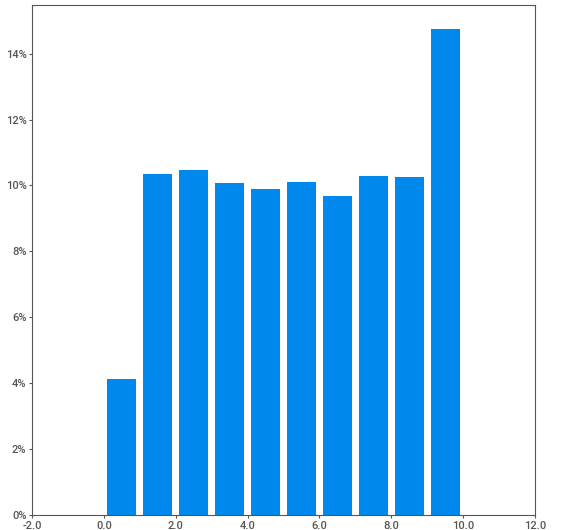
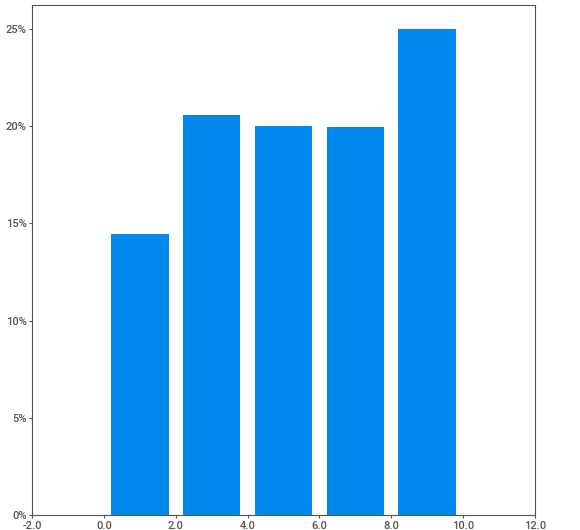
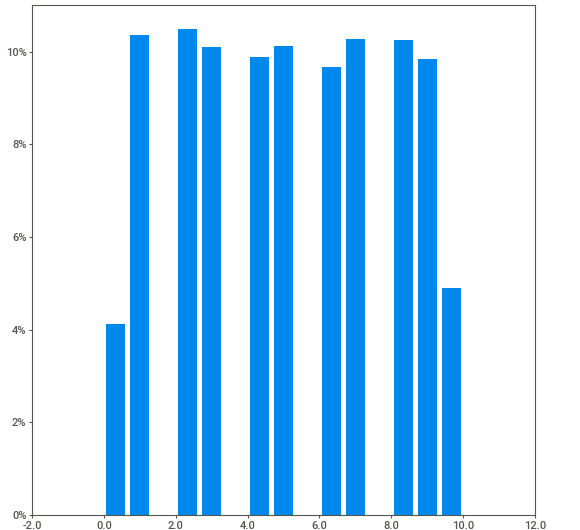
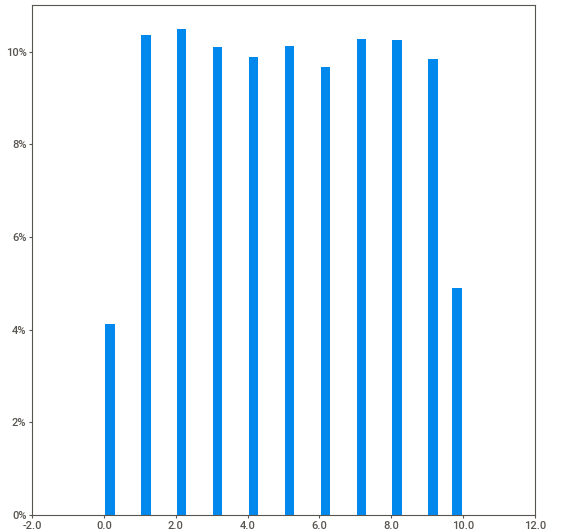
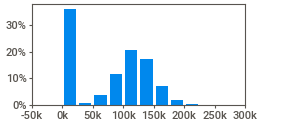
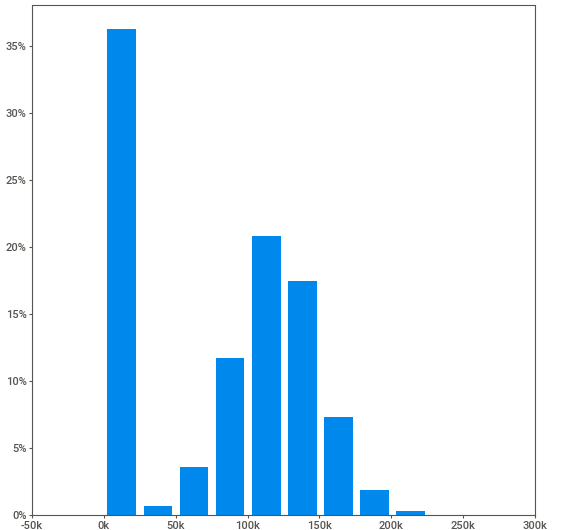
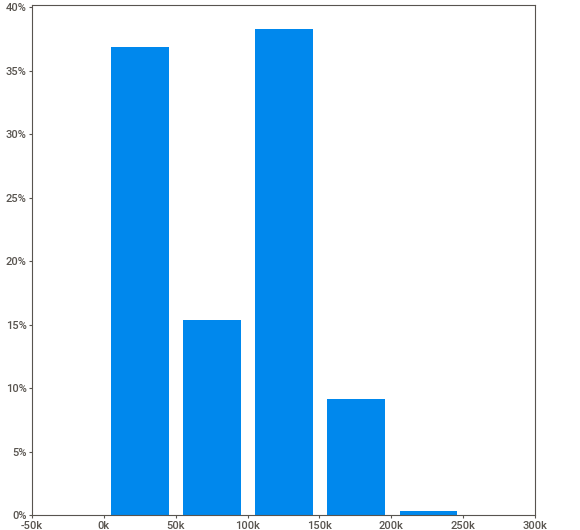
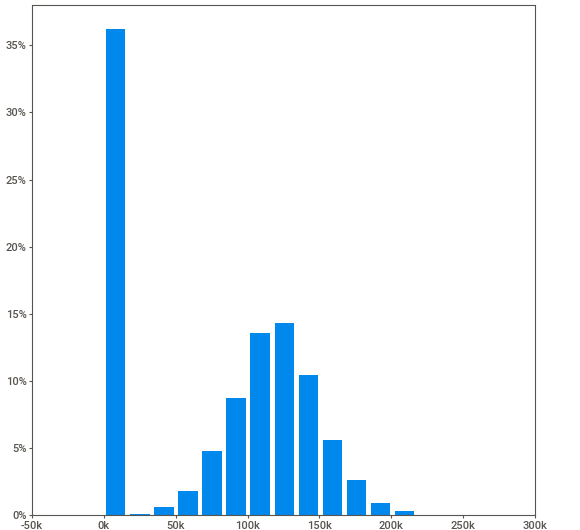
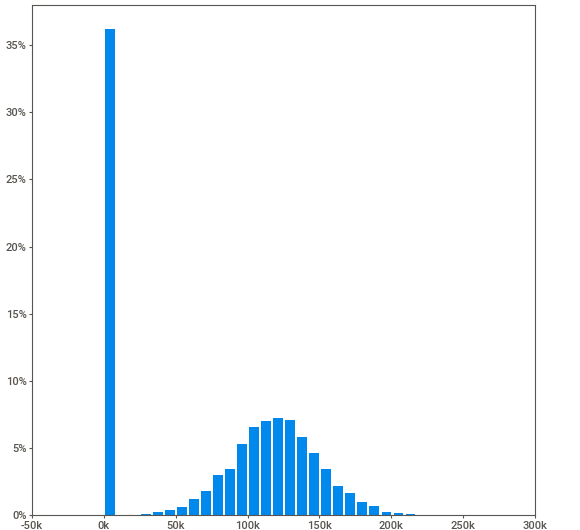
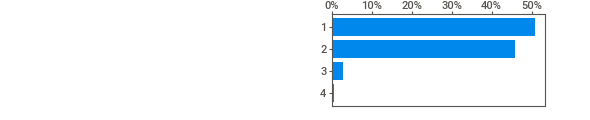
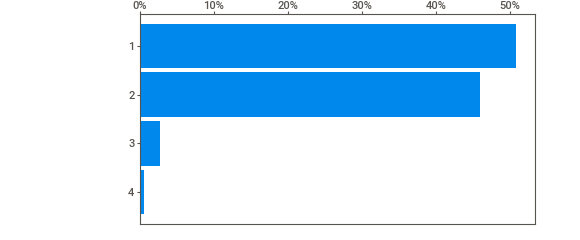
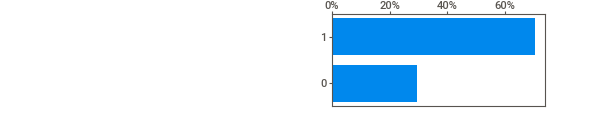
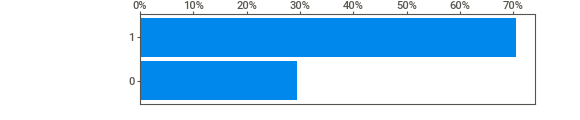
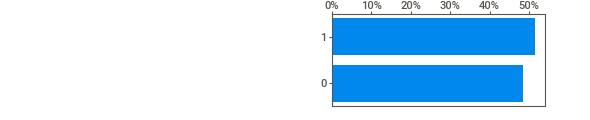
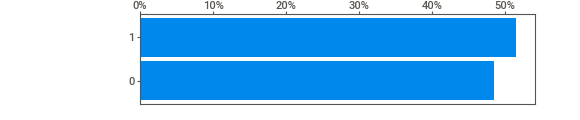
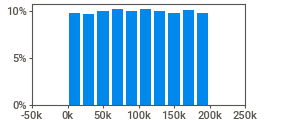
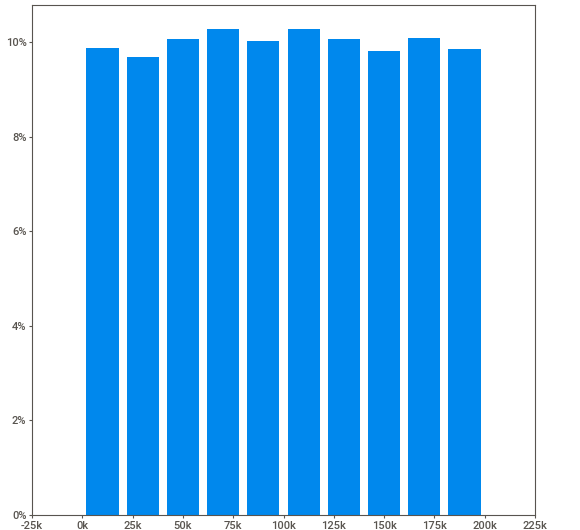
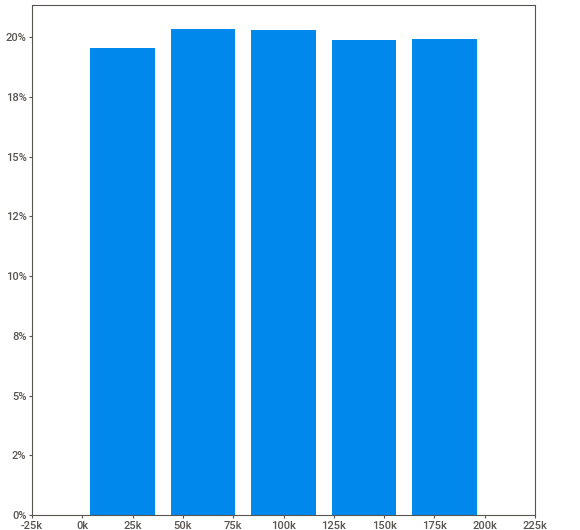
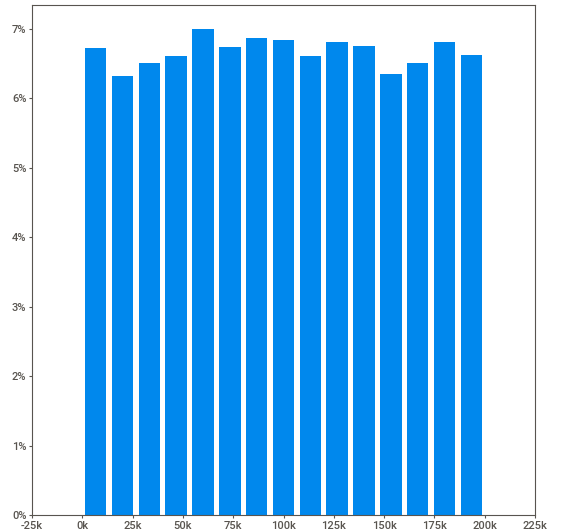
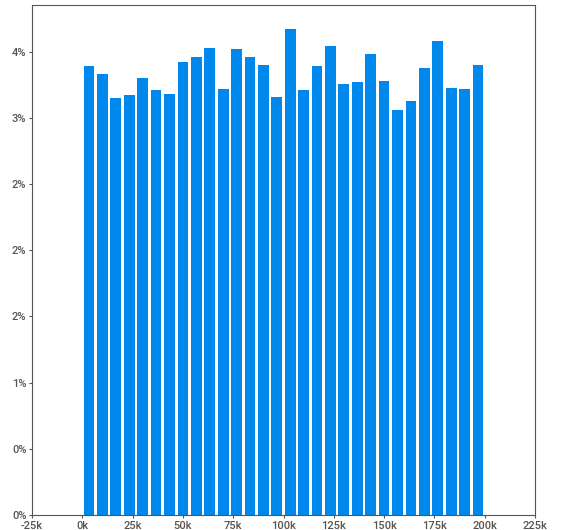
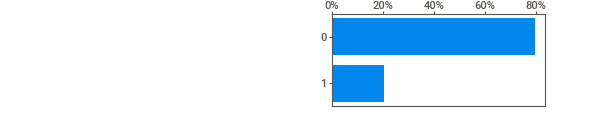
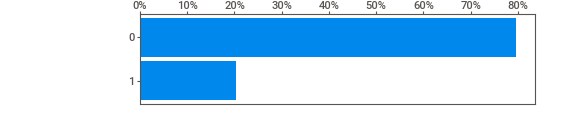
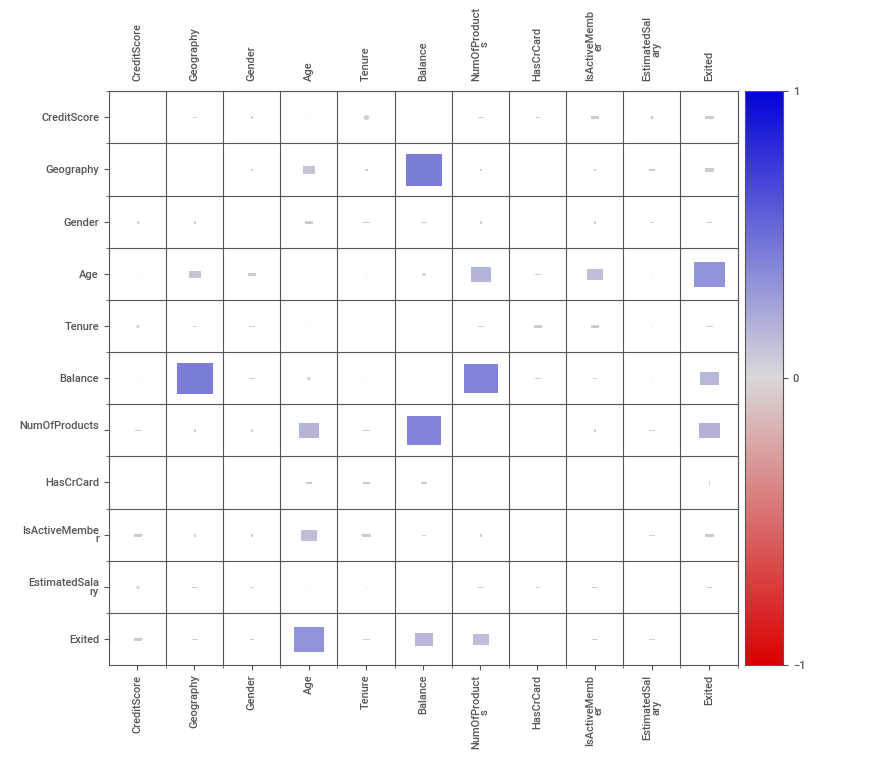
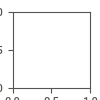

In [8]:
report = sv.analyze(churn)
report.show_notebook()

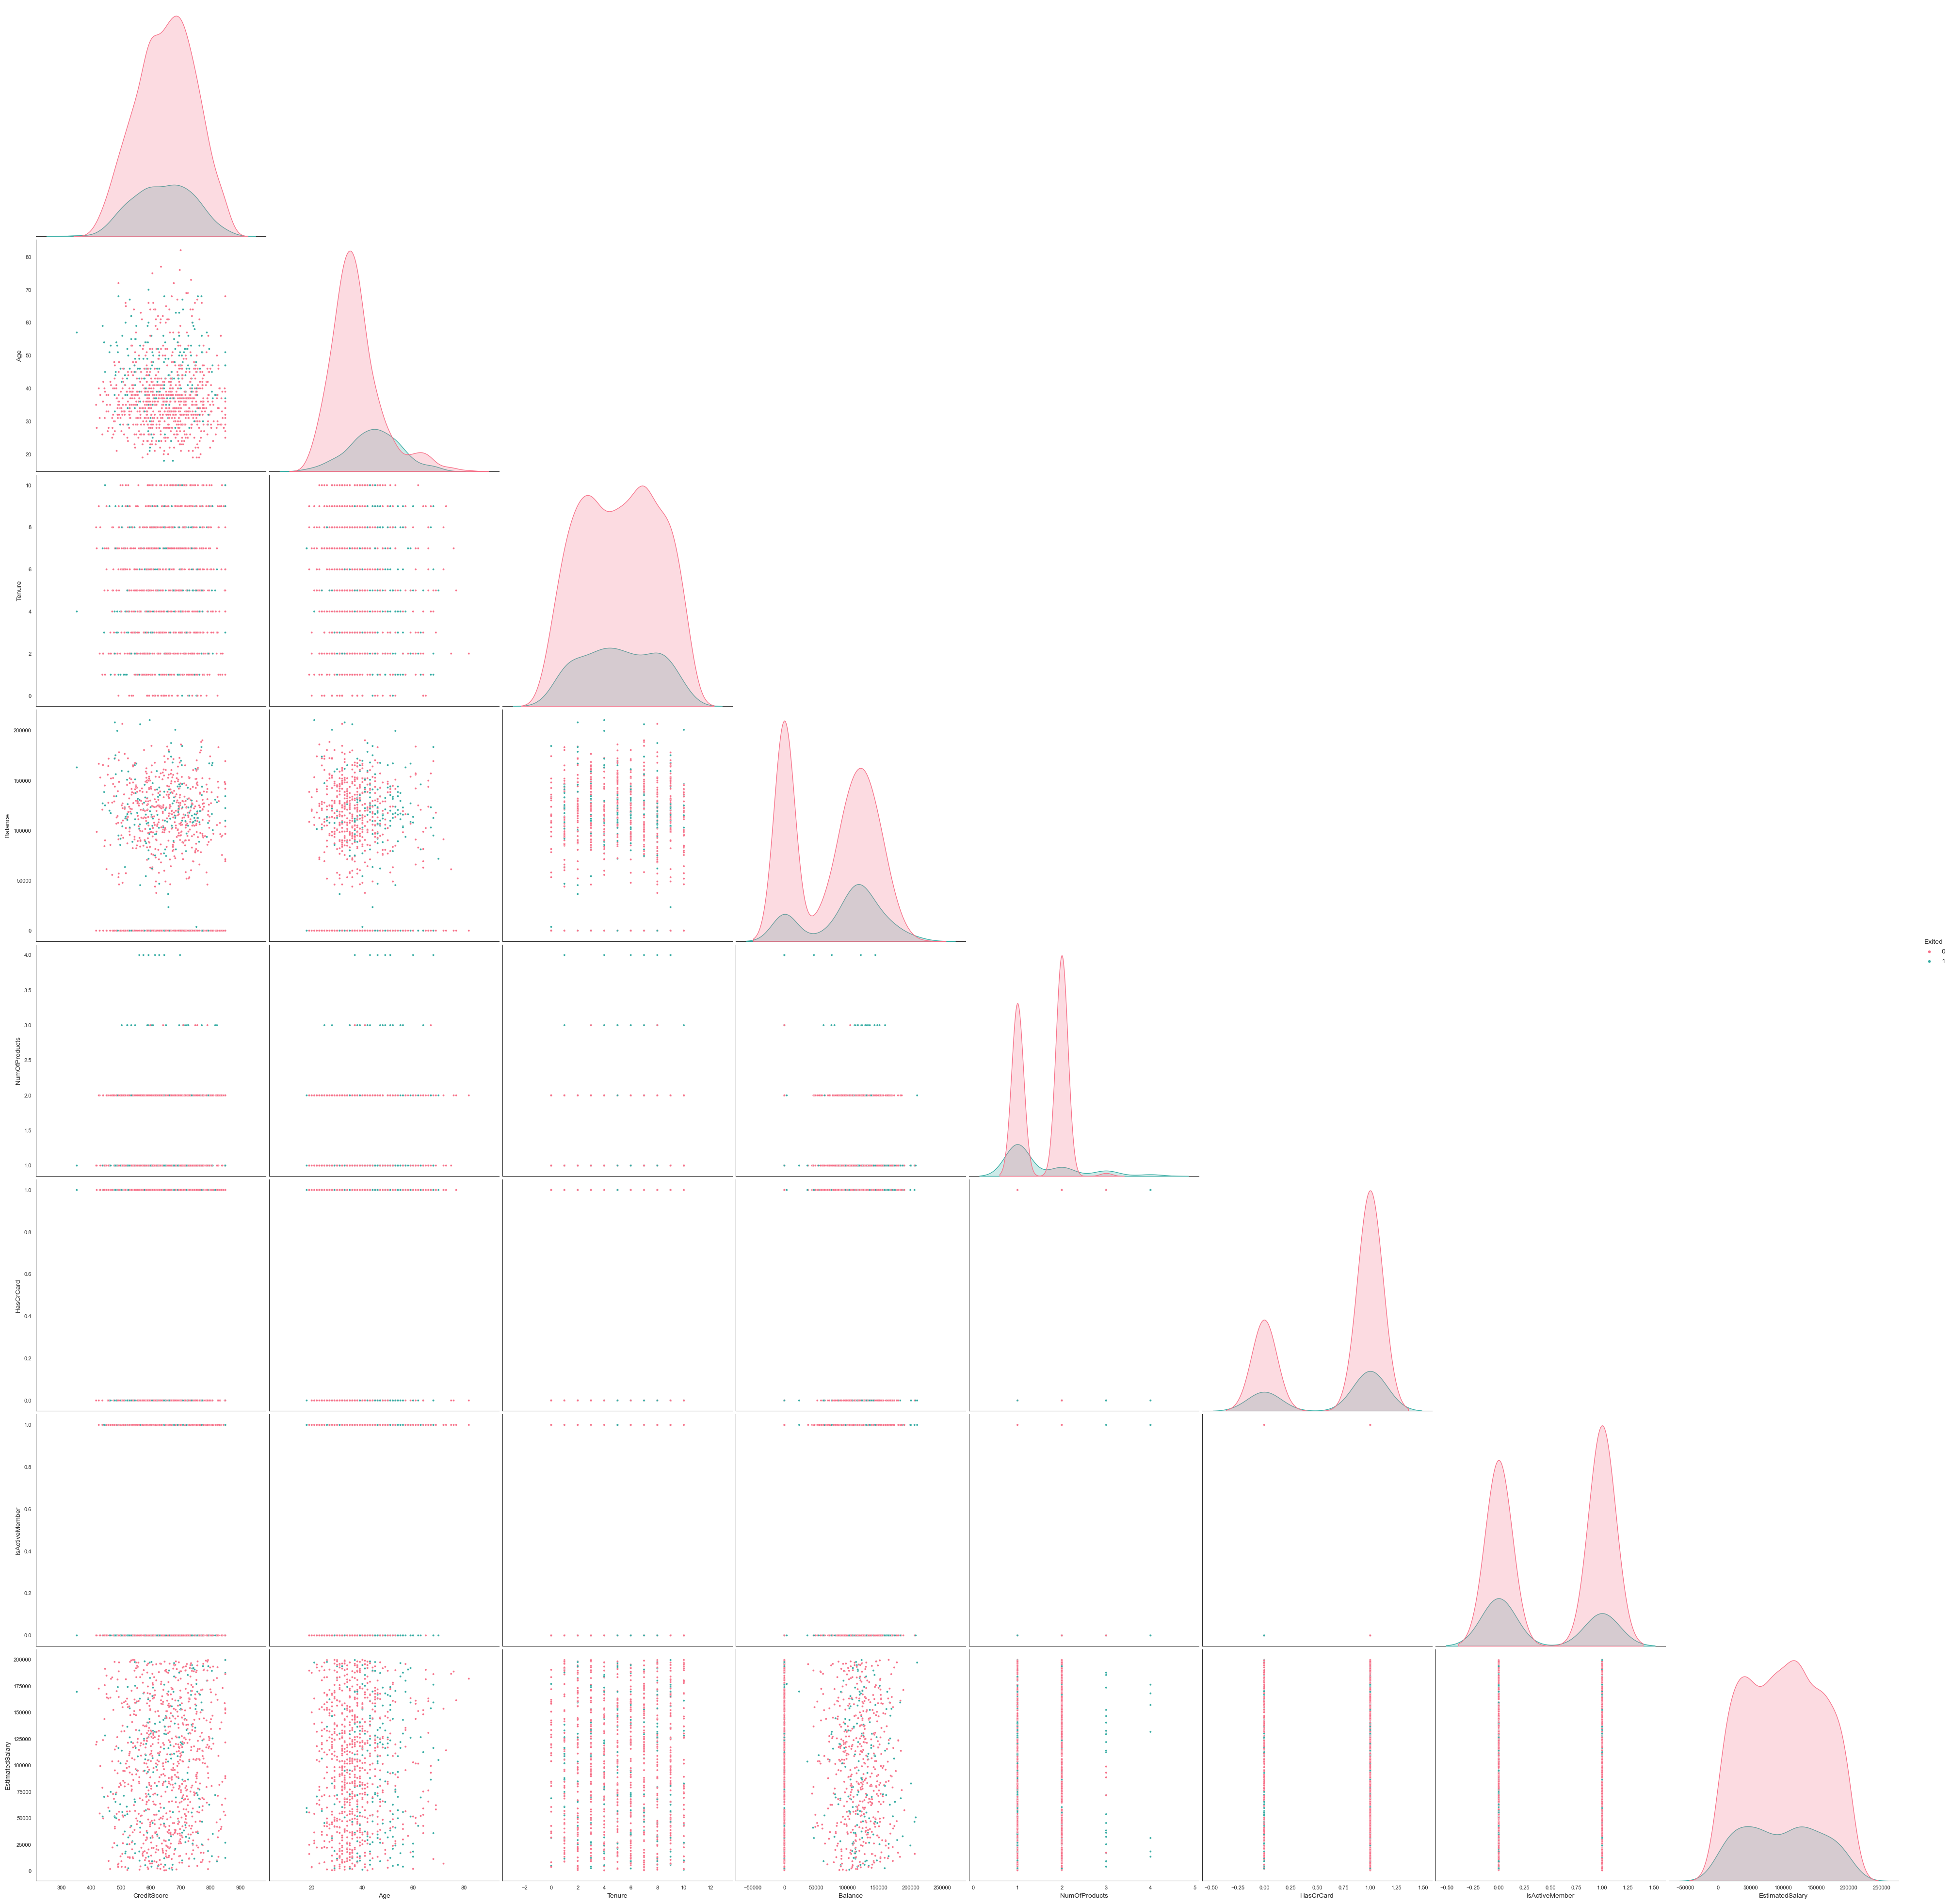

In [9]:
sns.set_style('white')
sns.pairplot(churn.sample(1000), hue='Exited', corner=True, palette=sns.husl_palette(n_colors=2), height=5)

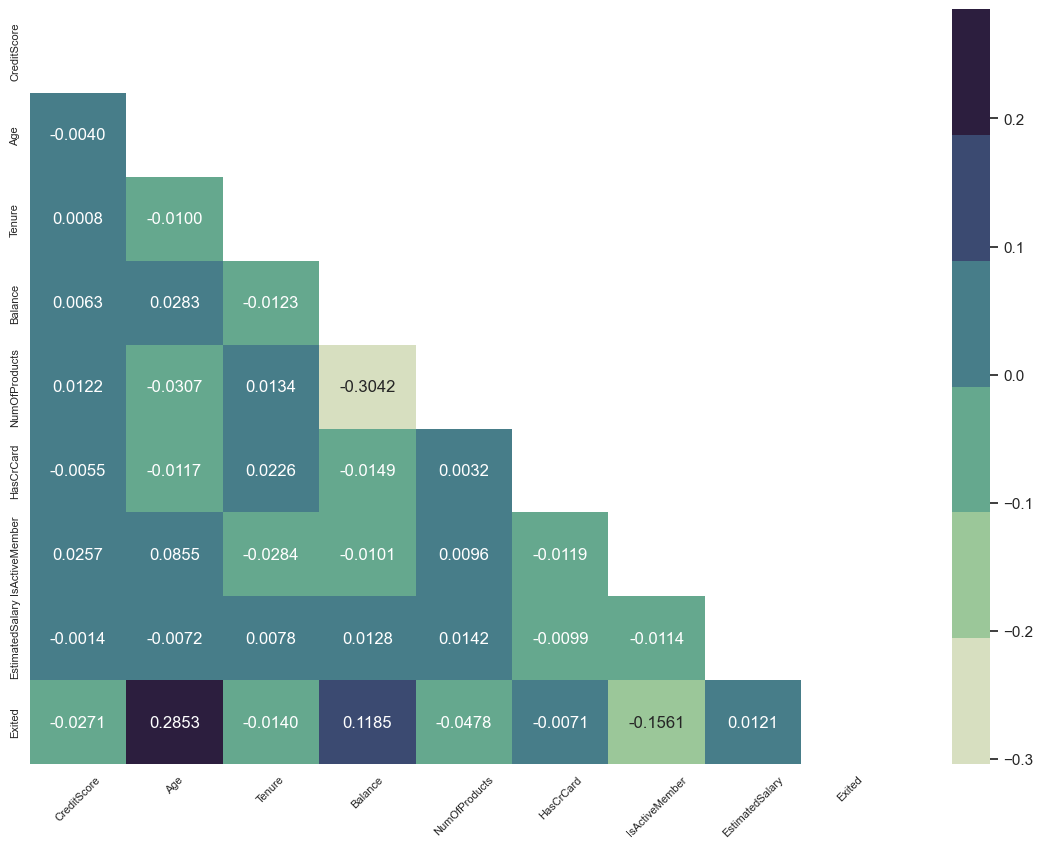

In [10]:
f, ax = plt.subplots(figsize=(14, 10))
sns.set_theme(style='darkgrid')
sns.heatmap(churn.corr(), annot=True, cmap=sns.cubehelix_palette(start=.5, rot=-.75),
            fmt= '.4f', mask= np.triu(churn.corr()), ax=ax)
plt.xticks(rotation=45)
plt.show()

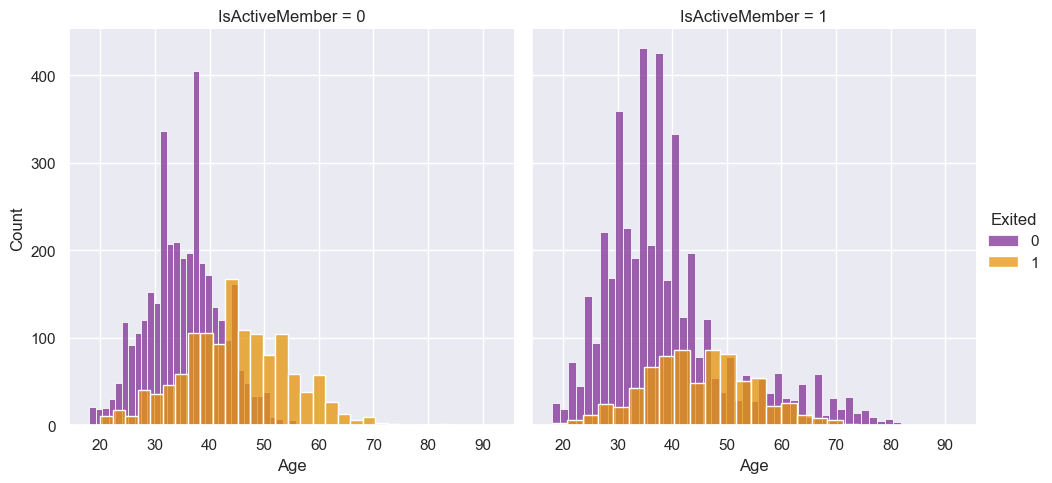

In [11]:
g = sns.FacetGrid(churn, col='IsActiveMember', hue='Exited', palette='CMRmap', size=5)
g.map(sns.histplot, 'Age')
g.add_legend()

<AxesSubplot:xlabel='CreditScore', ylabel='Count'>

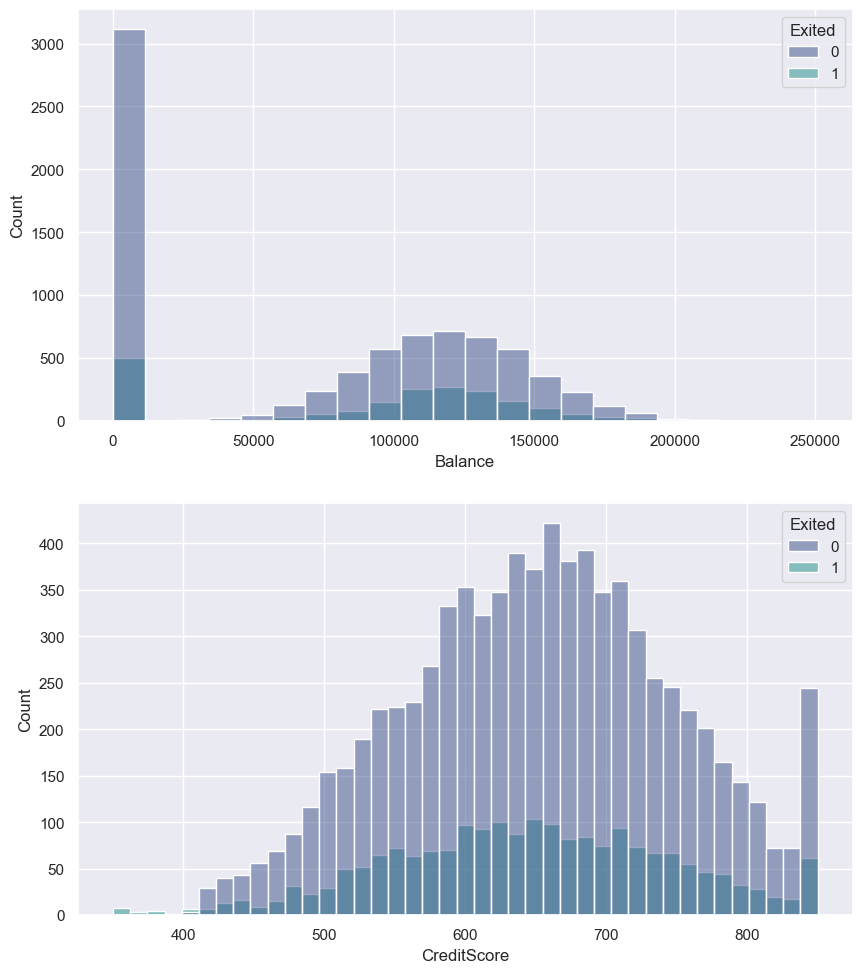

In [12]:
f, ax = plt.subplots(2, figsize=(10,12))

sns.set_palette('viridis', n_colors=3)
sns.histplot(ax=ax[0], x='Balance', hue='Exited', data=churn)
sns.histplot(ax=ax[1], x='CreditScore', hue='Exited', data=churn)

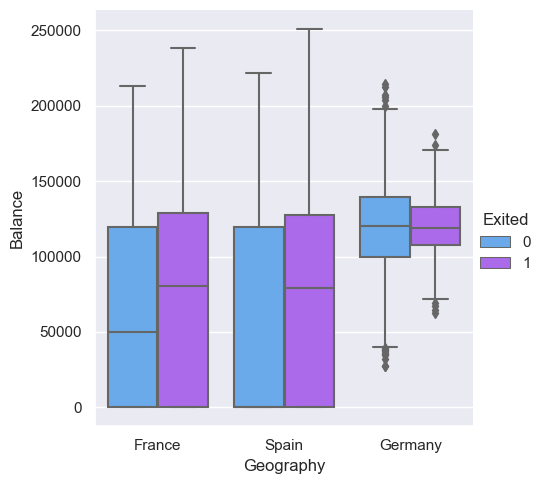

In [13]:
sns.catplot(x='Geography', y='Balance', hue='Exited', kind='box', data=churn, palette='cool')

In [14]:
churn[(churn['Geography'] == 'Spain') & (churn['Exited'] == 0)].Balance.quantile([0.5])

0.5    0.0
Name: Balance, dtype: float64

## Data preparation

### Log transformation of 'Age' Feature 

In [15]:
churn['LogAge'] = np.log(churn['Age'])

<AxesSubplot:xlabel='LogAge', ylabel='Count'>

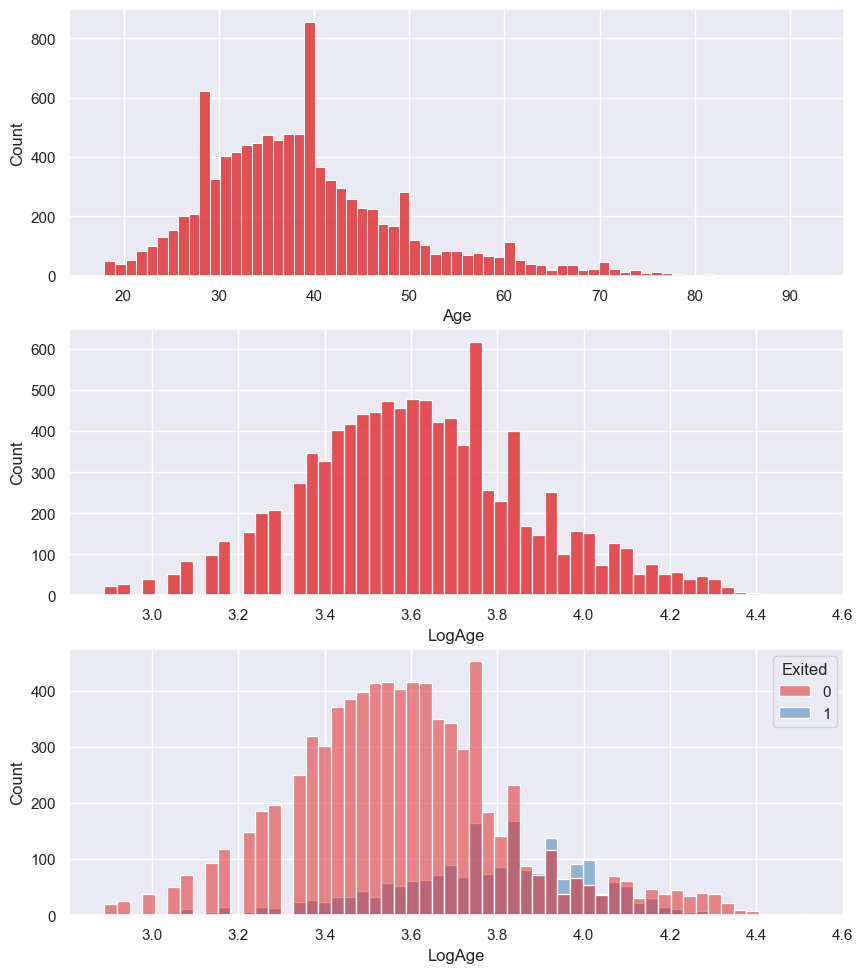

In [16]:
f, ax = plt.subplots(3, figsize=(10,12))

sns.set_palette('Set1', n_colors=3)
sns.histplot(ax=ax[0], x='Age', data=churn)
sns.histplot(ax=ax[1], x='LogAge', data=churn)
sns.histplot(ax=ax[2], x='LogAge', hue='Exited', data=churn)

In [17]:
skew = churn.skew()
skew = pd.DataFrame(skew, columns=['Variale skewness'])
skew.loc[['Age', 'LogAge']]

,Variale skewness
Age,1.01132
LogAge,0.18202


In [18]:
churn.drop(axis=1, columns=['Age'], inplace=True)

### Categorical features to dummies

In [19]:
churn = pd.get_dummies(churn, columns=['Geography', 'Gender'], drop_first=True)
churn.head()

,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,LogAge,Geography_Germany,Geography_Spain,Gender_Male
0,619,2,0.00,1,1,1,101348.88,1,3.737670,0,0,0
1,608,1,83807.86,1,0,1,112542.58,0,3.713572,0,1,0
2,502,8,159660.80,3,1,0,113931.57,1,3.737670,0,0,0
3,699,1,0.00,2,0,0,93826.63,0,3.663562,0,0,0
4,850,2,125510.82,1,1,1,79084.10,0,3.761200,0,1,0


### Multicollinearity test

In [20]:
X = add_constant(churn.drop(axis=1, columns=['Exited']))

pd.Series([variance_inflation_factor(X.values, i) 
           for i in range(X.shape[1])], 
           index=X.columns)

const                269.593391
CreditScore            1.001076
Tenure                 1.001961
Balance                1.336469
NumOfProducts          1.122294
HasCrCard              1.001583
IsActiveMember         1.007308
EstimatedSalary        1.000927
LogAge                 1.009106
Geography_Germany      1.339888
Geography_Spain        1.124678
Gender_Male            1.003166
dtype: float64

### Train-test split

In [21]:
X = churn.drop('Exited', axis=1)
y = churn['Exited']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=rndm)

### Features scaling

In [23]:
scaler = MaxAbsScaler()

In [24]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Modelling

In [129]:
result = pd.DataFrame(columns=['Algorithm', 'Accuracy', 'Precision', 'Recall', 'F-score', 'Roc_auc_score'])

def results(name):
    result.loc[len(result.index)] = [
        name, metrics.accuracy_score(y_test, y_pred), metrics.precision_score(y_test, y_pred),
        metrics.recall_score(y_test, y_pred), metrics.f1_score(y_test, y_pred),
        metrics.roc_auc_score(y_test, y_pred)
    ]

#### Logistic reggresion

In [130]:
lr = LogisticRegression(random_state=rndm)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [131]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.98      0.89      1593
           1       0.66      0.14      0.24       407

    accuracy                           0.81      2000
   macro avg       0.74      0.56      0.57      2000
weighted avg       0.79      0.81      0.76      2000



In [132]:
print("roc_auc_score: ", metrics.roc_auc_score(y_test, y_pred))
print("f1 score: ", metrics.f1_score(y_test, y_pred))

roc_auc_score:  0.5630653766246987
f1 score:  0.23790322580645162


In [133]:
results('Logistic regression')

#### Random forrest

In [134]:
rf = RandomForestClassifier(random_state=rndm)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [135]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1593
           1       0.74      0.43      0.54       407

    accuracy                           0.85      2000
   macro avg       0.81      0.69      0.73      2000
weighted avg       0.84      0.85      0.84      2000



In [136]:
print("roc_auc_score: ", metrics.roc_auc_score(y_test, y_pred))
print("f1 score: ", metrics.f1_score(y_test, y_pred))

roc_auc_score:  0.6936983208169649
f1 score:  0.540625


In [137]:
results('Random forrest')

#### Gaussian naive bayes

In [138]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

In [139]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      1593
           1       0.59      0.32      0.42       407

    accuracy                           0.82      2000
   macro avg       0.72      0.63      0.65      2000
weighted avg       0.79      0.82      0.79      2000



In [140]:
print("roc_auc_score: ", metrics.roc_auc_score(y_test, y_pred))
print("f1 score: ", metrics.f1_score(y_test, y_pred))

roc_auc_score:  0.6326850733630394
f1 score:  0.4171974522292993


In [141]:
results('Gaussian naive bayes')

#### Support vector classifier 

In [142]:
svc = SVC(random_state=rndm)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

In [143]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89      1593
           1       0.78      0.07      0.13       407

    accuracy                           0.81      2000
   macro avg       0.79      0.53      0.51      2000
weighted avg       0.80      0.81      0.74      2000



In [144]:
print("roc_auc_score: ", metrics.roc_auc_score(y_test, y_pred))
print("f1 score: ", metrics.f1_score(y_test, y_pred))

roc_auc_score:  0.5318870488362013
f1 score:  0.12641083521444696


In [145]:
results('Support vector classifier')

#### K-nearest neighbors

In [146]:
kn = KNeighborsClassifier()
kn.fit(X_train, y_train)
y_pred = kn.predict(X_test)

In [147]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1593
           1       0.47      0.23      0.31       407

    accuracy                           0.79      2000
   macro avg       0.65      0.58      0.59      2000
weighted avg       0.75      0.79      0.76      2000



In [148]:
print("roc_auc_score: ", metrics.roc_auc_score(y_test, y_pred))
print("f1 score: ", metrics.f1_score(y_test, y_pred))

roc_auc_score:  0.5831231848181
f1 score:  0.3119868637110016


In [149]:
results('K-nearest neighbors')

#### Linear discriminant analysis

In [150]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

In [151]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1593
           1       0.58      0.20      0.30       407

    accuracy                           0.81      2000
   macro avg       0.70      0.58      0.59      2000
weighted avg       0.77      0.81      0.77      2000



In [152]:
print("roc_auc_score: ", metrics.roc_auc_score(y_test, y_pred))
print("f1 score: ", metrics.f1_score(y_test, y_pred))

roc_auc_score:  0.5819047090233531
f1 score:  0.2987249544626594


In [153]:
results('Linear discriminant analysis')

#### XGBoost 

In [154]:
xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [155]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1593
           1       0.70      0.45      0.55       407

    accuracy                           0.85      2000
   macro avg       0.79      0.70      0.73      2000
weighted avg       0.84      0.85      0.84      2000



In [156]:
print("roc_auc_score: ", metrics.roc_auc_score(y_test, y_pred))
print("f1 score: ", metrics.f1_score(y_test, y_pred))

roc_auc_score:  0.7027906180448554
f1 score:  0.5522388059701493


In [157]:
results('XGBoost classifier')

### Results comaprison

In [158]:
result.style.highlight_max(subset=['Accuracy', 'Precision', 'Recall', 'F-score', 'Roc_auc_score'], color='Cyan')

,Algorithm,Accuracy,Precision,Recall,F-score,Roc_auc_score
0,Logistic regression,0.811000,0.662921,0.144963,0.237903,0.563065
1,Random forrest,0.853000,0.742489,0.425061,0.540625,0.693698
2,Gaussian naive bayes,0.817000,0.592760,0.321867,0.417197,0.632685
3,Support vector classifier,0.806500,0.777778,0.068796,0.126411,0.531887
4,K-nearest neighbors,0.790500,0.470297,0.233415,0.311987,0.583123
5,Linear discriminant analysis,0.807500,0.577465,0.201474,0.298725,0.581905
6,XGBoost classifier,0.850000,0.703422,0.454545,0.552239,0.702791


### ROC/AUC comparison plots

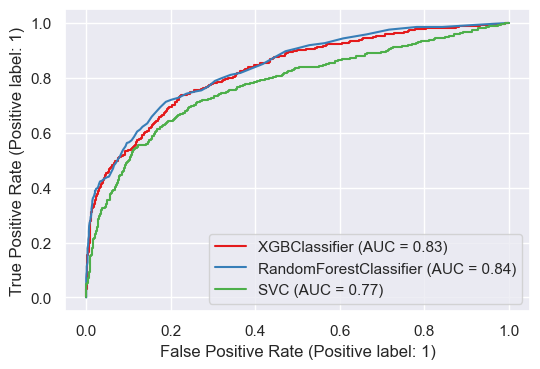

In [159]:
classifiers = [xgb, rf, svc]
ax = plt.gca()
for i in classifiers:
    metrics.plot_roc_curve(i, X_test, y_test, ax=ax)

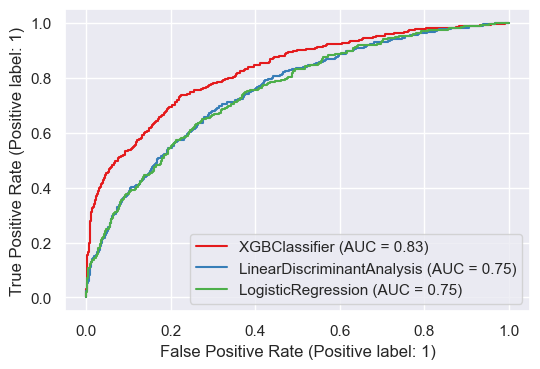

In [160]:
classifiers = [xgb, lda,lr]
ax = plt.gca()
for i in classifiers:
    metrics.plot_roc_curve(i, X_test, y_test, ax=ax)

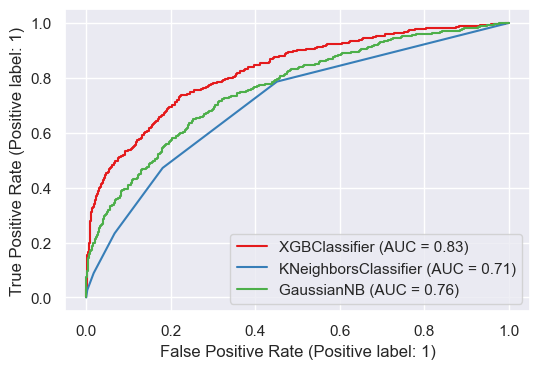

In [161]:
classifiers = [xgb, kn, nb]
ax = plt.gca()
for i in classifiers:
    metrics.plot_roc_curve(i, X_test, y_test, ax=ax)

### Hyperparameters tuning

In [162]:
result.drop(axis=0, index=[0,2,4,5], inplace=True)
result.reset_index(inplace=True)
result.drop(axis=1, columns=['index'], inplace=True)
result

,Algorithm,Accuracy,Precision,Recall,F-score,Roc_auc_score
0,Random forrest,0.8530,0.742489,0.425061,0.540625,0.693698
1,Support vector classifier,0.8065,0.777778,0.068796,0.126411,0.531887
2,XGBoost classifier,0.8500,0.703422,0.454545,0.552239,0.702791


#### Random Forrest

In [109]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

parameters = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(parameters)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [110]:
rf_rnd = RandomizedSearchCV(estimator=rf, param_distributions=parameters, n_jobs=-1, random_state=rndm)
rf_rnd.fit(X_train, y_train)

print("The best score across all searched params: ", rf_rnd.best_score_)
print("\n The best parameters across all searched params:\n", rf_rnd.best_params_)

The best score across all searched params:  0.866875

 The best parameters across all searched params:
 {'n_estimators': 2000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': True}


In [111]:
rf_grid = RandomForestClassifier(bootstrap=True, max_features='auto', random_state=rndm)
parameters = {'n_estimators': [1800, 2000],
              'max_depth': [40, 45],
              'min_samples_split': [8, 10, 12],
              'min_samples_leaf': [1, 2, 3],
              }

gridCV = GridSearchCV(rf_grid, parameters, cv=5, n_jobs=-1)
gridCV.fit(X_train, y_train)
print('Best parameters:' + str(gridCV.best_params_))
print('Best accuracy in cross-validation:' + str(gridCV.best_score_))

Best parameters:{'max_depth': 40, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 1800}
Best accuracy in cross-validation:0.867


In [163]:
rf_t = RandomForestClassifier(max_depth=40, min_samples_leaf=2, min_samples_split=10,
                            n_estimators=1800, bootstrap=True, max_features='auto',
                            random_state=rndm)
rf_t.fit(X_train, y_train)
y_pred = rf_t.predict(X_test)

In [164]:
results('Random forrest tuned')

#### XGBoost

In [114]:
eta = [float(x) for x in np.linspace(start=0.01, stop=0.39, num=10)]
gamma= [0, 0.1, 0.2]
max_depth = [4, 6, 8]
min_child_weight = [float(x) for x in np.linspace(start=0, stop=4, num=9)]
subsample = [float(x) for x in np.linspace(start=0.6, stop=1.0, num=5)]

parameters = {'eta': eta,
              'gamma': gamma,
              'max_depth': max_depth,
              'min_child_weight': min_child_weight,
              'subsample': subsample
             }

print(parameters)

{'eta': [0.01, 0.052222222222222225, 0.09444444444444444, 0.1366666666666667, 0.1788888888888889, 0.22111111111111112, 0.26333333333333336, 0.3055555555555556, 0.3477777777777778, 0.39], 'gamma': [0, 0.1, 0.2], 'max_depth': [4, 6, 8], 'min_child_weight': [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0], 'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]}


In [115]:
xgb_rnd = RandomizedSearchCV(estimator=xgb, param_distributions=parameters, n_jobs=-1, random_state=rndm)
xgb_rnd.fit(X_train, y_train)

print("The best score across all searched params: ", xgb_rnd.best_score_)
print("\n The best parameters across all searched params:\n", xgb_rnd.best_params_)

The best score across all searched params:  0.858625

 The best parameters across all searched params:
 {'subsample': 0.7, 'min_child_weight': 1.0, 'max_depth': 4, 'gamma': 0.1, 'eta': 0.1366666666666667}


In [116]:
parameters = {'eta': [0.13,0.14,0.15],
              'gamma': [0.09,0.1,0.11],
              'max_depth': [3,4,5],
              'min_child_weight': [0.09,1.0,0.11],
              'subsample': [0.6,0.7,0.8]
             }

gridCV = GridSearchCV(xgb, parameters, cv=5, n_jobs=-1)
gridCV.fit(X_train, y_train)
print('Best parameters:' + str(gridCV.best_params_))
print('Best accuracy in cross-validation:' + str(gridCV.best_score_))

Best parameters:{'eta': 0.13, 'gamma': 0.09, 'max_depth': 3, 'min_child_weight': 0.09, 'subsample': 0.7}
Best accuracy in cross-validation:0.864625


In [117]:
xgb_grid = XGBClassifier(subsample=0.7, eval_metric='logloss')

parameters = {'eta': [0.11,0.12,0.13],
              'gamma': [0.07,0.08,0.09],
              'max_depth': [1,2,3],
              'min_child_weight': [0.07,0.08,0.09]
             }

gridCV = GridSearchCV(xgb_grid, parameters, cv=5, n_jobs=-1)
gridCV.fit(X_train, y_train)
print('Best parameters:' + str(gridCV.best_params_))
print('Best accuracy in cross-validation:' + str(gridCV.best_score_))

Best parameters:{'eta': 0.12, 'gamma': 0.07, 'max_depth': 3, 'min_child_weight': 0.09}
Best accuracy in cross-validation:0.867125


In [118]:
xgb_grid = XGBClassifier(subsample=0.7, max_depth=3, min_child_weight=0.09, eta=0.12, eval_metric='logloss')

parameters = {'gamma': [0.03,0.04,0.05,0.06,0.07]}

gridCV = GridSearchCV(xgb_grid, parameters, cv=5, n_jobs=-1)
gridCV.fit(X_train, y_train)
print('Best parameters:' + str(gridCV.best_params_))
print('Best accuracy in cross-validation:' + str(gridCV.best_score_))

Best parameters:{'gamma': 0.04}
Best accuracy in cross-validation:0.8672500000000001


In [165]:
xgb_t = XGBClassifier(subsample=0.7, max_depth=3, min_child_weight=0.09, eta=0.12, gamma=0.04, eval_metric='logloss')
xgb_t.fit(X_train, y_train)
y_pred = xgb_t.predict(X_test)

In [166]:
results("XG boost tuned")
result

,Algorithm,Accuracy,Precision,Recall,F-score,Roc_auc_score
0,Random forrest,0.8530,0.742489,0.425061,0.540625,0.693698
1,Support vector classifier,0.8065,0.777778,0.068796,0.126411,0.531887
2,XGBoost classifier,0.8500,0.703422,0.454545,0.552239,0.702791
3,Random forrest tuned,0.8555,0.758772,0.425061,0.544882,0.695268
4,XG boost tuned,0.8545,0.756637,0.420147,0.540284,0.692811


#### Support vector classifier

In [121]:
kernel = ['rbf', 'poly']
C = [float(x) for x in np.logspace(-1,2,5)]
gamma = ['auto', 'scale']

In [122]:
parameters = {'kernel': kernel, 'C': C, 'gamma': gamma}
svc_rnd = RandomizedSearchCV(estimator=svc, param_distributions=parameters, n_jobs=-1, random_state=rndm)
svc_rnd.fit(X_train, y_train)

print("The best score across all searched params: ", svc_rnd.best_score_)
print("\n The best parameters across all searched params:\n", svc_rnd.best_params_)

The best score across all searched params:  0.8541250000000001

 The best parameters across all searched params:
 {'kernel': 'rbf', 'gamma': 'scale', 'C': 17.78279410038923}


In [123]:
gridCV = GridSearchCV(svc, param_grid={'C':[10,20,30,40,50]}, cv=5, n_jobs=-1)
gridCV.fit(X_train, y_train)
print('Best parameters:' + str(gridCV.best_params_))
print('Best accuracy in cross-validation:' + str(gridCV.best_score_))

Best parameters:{'C': 20}
Best accuracy in cross-validation:0.8540000000000001


In [124]:
gridCV = GridSearchCV(svc, param_grid={'C':[16,18,20,22,24]}, cv=5, n_jobs=-1)
gridCV.fit(X_train, y_train)
print('Best parameters:' + str(gridCV.best_params_))
print('Best accuracy in cross-validation:' + str(gridCV.best_score_))

Best parameters:{'C': 22}
Best accuracy in cross-validation:0.8546250000000001


In [167]:
svc_t = SVC(C=22, random_state=rndm)
svc_t.fit(X_train, y_train)
y_pred = svc_t.predict(X_test)

In [168]:
results('Support vector tuned')

In [169]:
result.style.highlight_max(subset=['Accuracy', 'Precision', 'Recall', 'F-score', 'Roc_auc_score'], color='Turquoise')

,Algorithm,Accuracy,Precision,Recall,F-score,Roc_auc_score
0,Random forrest,0.853000,0.742489,0.425061,0.540625,0.693698
1,Support vector classifier,0.806500,0.777778,0.068796,0.126411,0.531887
2,XGBoost classifier,0.850000,0.703422,0.454545,0.552239,0.702791
3,Random forrest tuned,0.855500,0.758772,0.425061,0.544882,0.695268
4,XG boost tuned,0.854500,0.756637,0.420147,0.540284,0.692811
5,Support vector tuned,0.842000,0.726368,0.358722,0.480263,0.662098
